# Predicting APS Failure in Scania Trucks using Random Forest Classifier

### Our goal is to minimize the cost associated with:
###     1) Unnecessary random checks done by mechanic 
###     2) Missing a faulty truck, which may cause breakdown


###### Reference - https://medium.com/swlh/aps-failure-at-scania-trucks-203975cdc2dd
###### Source - https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks

In [1]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import imblearn as imb
import sklearn.ensemble as ens
import sklearn.preprocessing as std
import sklearn.metrics as sklearn

# Import training and testing datasets

### Read train and test datasets into dataframe format

In [2]:
# Datasets are placed in the same folder as notebook

trainingDf = pd.read_csv('./aps_failure_training_set.csv', na_values = "na")
testDf = pd.read_csv('./aps_failure_test_set.csv', na_values = "na")

### Convert NEG and POS values in Train datasets to 0 and 1 respectively

In [3]:
# Assign 1 for POS and 0 for NEG for columns class

class_labels = []

for values in trainingDf['class']:
    if values == 'neg':
        class_labels.append(0)
    else:
        class_labels.append(1)

trainingDf['class'] = class_labels

### Visualize the distribution of NaN values to remove columns with large number of NaN

In [4]:
y_train = trainingDf['class']
trainingDf.drop(['class'],axis = 1,inplace = True)

In [5]:
trainingDf.replace(to_replace = 'NaN', value = np.NaN, inplace = True)
trainingDf.replace(to_replace = 'na', value = np.NaN, inplace = True)

## Before Imputations (Unbalanced data)

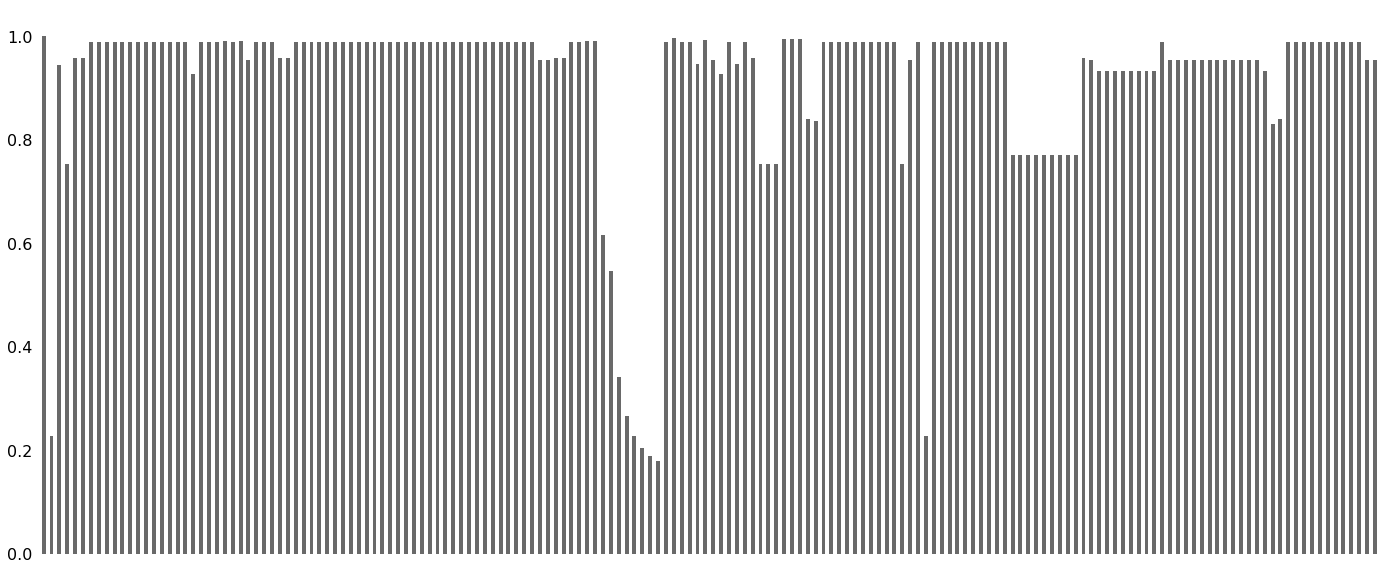

In [6]:
# Finding the accurate threshold to remove the columns with more 0 using msno library

msno.bar(trainingDf[trainingDf.columns[0:]])

In [7]:
trainingDf.dropna(axis = 1, thresh = 42000, inplace = True)

# Imputation to fill in NaN column values

## Medium Imputation 

Calculates the medium values in the NaN columns, and fill in those created values within each column independently from others



In [8]:
impute_median = SimpleImputer(missing_values = np.nan, strategy = 'median', copy = True, verbose = 2)
trainDf_withMedian = pd.DataFrame(impute_median.fit_transform(trainingDf), columns = trainingDf.columns)
trainDf_withMedian.to_csv("TRAIN_IMPUTED_WITH_MEDIAN")

# Preparing the test datasets

In [9]:
y_test = testDf['class']
testDf.drop(['class'],axis = 1, inplace = True)

### Convert NEG and POS values in Test datasets to 0 and 1 respectively

In [10]:
# Assign 0 to NEG and 1 to POS

test_class_labels = []

for values in y_test:
    if values == 'neg':
        test_class_labels.append(0)
    else:
        test_class_labels.append(1)

y_test = test_class_labels

In [11]:
testDf = testDf[trainingDf.columns]

## Medium Imputation

Calculates the medium values in the NaN columns, and fill in those created values within each column independently from others

In [12]:
# Replace 'na' and 'nan' values to np.NaN

testDf.replace(to_replace = ['na','nan'], value = np.NaN, inplace = True)

In [13]:
testDf_withMedian = pd.DataFrame(impute_median.fit_transform(testDf), columns = testDf.columns)
testDf_withMedian.to_csv("TEST_IMPUTED_WITH_MEDIAN")

## After Imputations (Balanced Data)

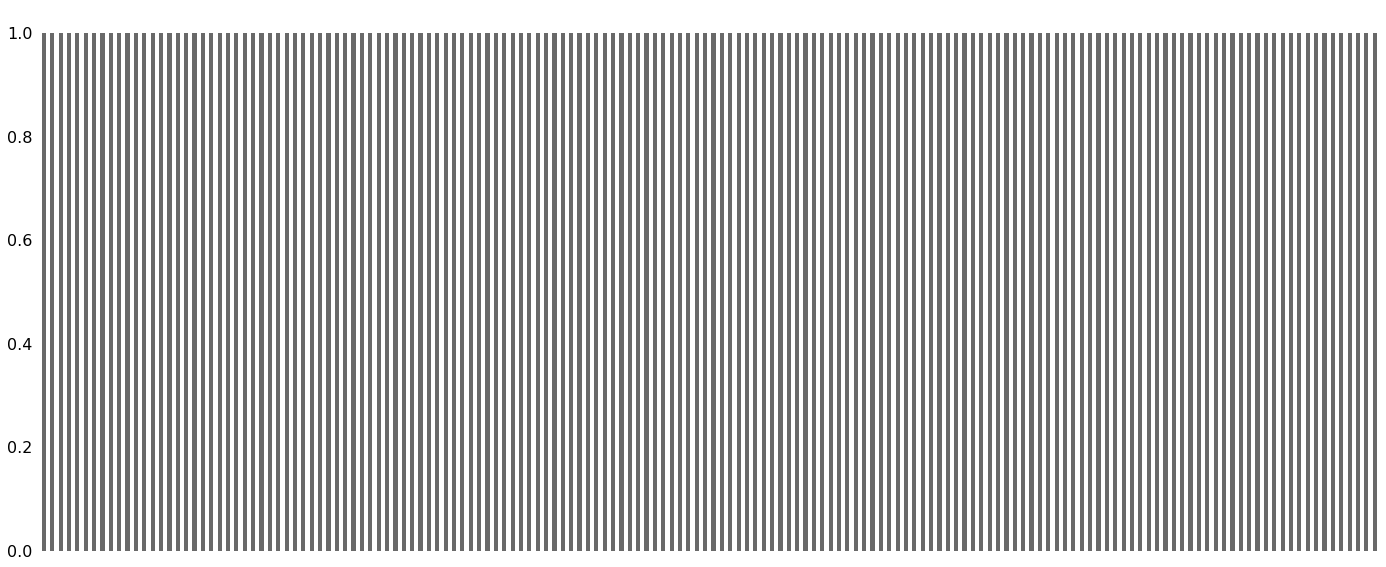

In [14]:
msno.bar(trainDf_withMedian[trainDf_withMedian.columns[0:]])

## Load in Train and Test datasets for prediction

In [15]:
y_train.to_csv('y_train.csv')
y_test = pd.DataFrame(y_test)
y_test.to_csv('y_test.csv')

# Preparing the Test datasets 

## Read and drop unused columns in Test dataset

In [16]:
# Reading the files

train = pd.read_csv("TRAIN_IMPUTED_WITH_MEDIAN")
test = pd.read_csv("TEST_IMPUTED_WITH_MEDIAN")
y_train = pd.read_csv("y_train.csv")
y_test = pd.read_csv("y_test.csv")

In [17]:
# Dropping certain columns to ensure same shape size

y_train.drop(['Unnamed: 0'], axis = 1,inplace = True)
y_test.drop(['Unnamed: 0'], axis = 1,inplace = True)
test.drop(['Unnamed: 0'], axis = 1,inplace = True)
train.drop(['Unnamed: 0'], axis = 1,inplace = True)

In [18]:
train['class'] = y_train

In [19]:
print('Total NEGATIVE classes are {} and total POSITIVE classes are {}'.format(train['class'].value_counts()[0], train['class'].value_counts()[1]))

Total NEGATIVE classes are 59000 and total POSITIVE classes are 1000


## Visualise the spread of POS and NEG classes

Text(0.5, 1.0, 'Spread of Negative and Positive observations')

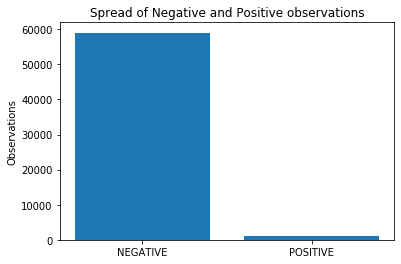

In [20]:
plt.bar(['NEGATIVE', 'POSITIVE'], [train['class'].value_counts()[0], train['class'].value_counts()[1]])
plt.ylabel('Observations')
plt.title('Spread of Negative and Positive observations')

## Upsampling and Downsampling is done to reduce the imbalance 

In [35]:
# Undersampling the NEG class

train_neg_sampled = train[train['class'] == 0].sample(n = 10000, random_state = 42)
train_Sampled = train[train['class'] == 1].append(train_neg_sampled)

y_train = train_Sampled['class']
train_Sampled.drop(['class'], axis = 1, inplace = True)

# Upsampling the positive class using SMOTE Technique

smote = imb.over_sampling.SMOTE(k_neighbors = 1)
train_Sampled_Smote, y_train = smote.fit_sample(train_Sampled, y_train)

## SMOTE technique is used to create synthetic variables

1) The red dots represents the minority classes where upsampling is needed

2) The SMOTE algorithim works by creating new (minority) classes values by calculating the distances between the minority labels. Using a particular K value, synthetic values are created which will be bounded by the radius of the neighbourhood. 


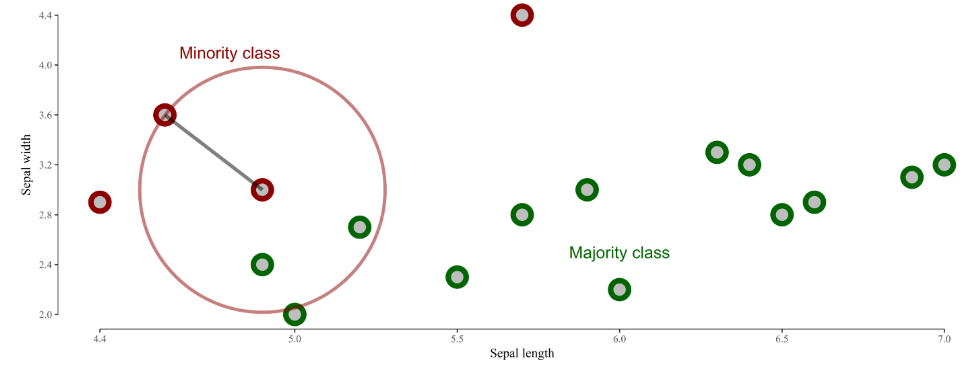

SOURCE - http://rikunert.com/SMOTE_explained


In [22]:
# Standardising the data

trainStandard = std.StandardScaler().fit_transform(train_Sampled_Smote)
testStandard = std.StandardScaler().fit_transform(test)

## Random Forest Prediction usind Medium Imputations

In [32]:
# Creating a RFP model for prediction model

clf = ens.RandomForestClassifier(n_estimators = 1000, max_depth = 1000, n_jobs = -1)
clf.fit(trainStandard, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

## Calculating the total cost by formulating the confusion matrix

#### Total cost = FN * 500 + FP *10, where FN is Error 1 and EP is Error 2. The goal is to minimise the total cost.

In [33]:
# Perform prediction using test data

y_pred = clf.predict(testStandard)
conMat = sklearn.confusion_matrix(y_test, y_pred)

In [34]:
print('Total predicted cost using Random Forest Classifier = ${}.'.format(conMat[1][1]*10 + conMat[1][0]*500))

Total predicted cost using Random Forest Classifier = $12570.


# What else can we try to reduce the cost?

## 1) Dimensionality reduction using Principal Component Analysis (PCA)
## 2) Dimensionality reduction using Singular Value Decomposition (SVD)
## 3) Over sampling using Adaptive Synthetic (ADASYN) 
## 4) Perform Cross Validation to find optimal parameters for Random Forest Prediction